***Welcome to Medical image processing in Python***<br/>

Presented by: Reza Saadatyar (2024-2025) <br/>
E-mail: Reza.Saadatyar@outlook.com 

<font color='#FF000e' size="4.8" face="Arial"><b>Import modules</b></font>

In [2]:
import sys
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from colorama import Back, Fore
# from skimage.viewer import ImageViewer

from Functions.filepath_extractor import FilePathExtractor

**1. Set Image Path & Load data**

In [4]:
file_path = "D:/Medical-Image-Processing/Data/Inputs"

# Create an instance of DirectoryReader with the directory path and file format
obj_path = FilePathExtractor(directory_path=file_path, format_type="tif")
file_names = obj_path.filenames          # List of filenames in the directory with the specified extension
folder = obj_path.folder_paths           # List of folder paths where the files are located
file_paths = obj_path.all_file_paths     # List of full file paths for the files
subfoldernames = obj_path.subfoldernames # List of subfolder names within the directory

print(Fore.GREEN + f"{file_names = }""\n" + Fore.BLUE + f"{folder = }""\n" + Fore.MAGENTA + f"{file_paths = }"+
      "\n" + Fore.CYAN + f"{subfoldernames = }")

file_names = ['ytma12_010804_benign2_ccd.tif', 'ytma12_010804_benign3_ccd.tif', 'ytma12_010804_malignant1_ccd.tif', 'ytma12_010804_malignant2_ccd.tif', 'ytma12_010804_malignant3_ccd.tif', 'ytma23_022103_benign1_ccd.tif', 'ytma23_022103_benign2_ccd.tif', 'ytma23_022103_benign3_ccd.tif', 'ytma23_022103_malignant1_ccd.tif', 'ytma23_022103_malignant2_ccd.tif', 'ytma23_022103_malignant3_ccd.tif', 'ytma49_042003_benign1_ccd.tif', 'ytma49_042003_benign2_ccd.tif', 'ytma49_042003_benign3_ccd.tif', 'ytma49_042003_malignant1_ccd.tif', 'ytma49_042003_malignant2_ccd.tif', 'ytma49_042003_malignant3_ccd.tif', 'ytma49_042203_benign1_ccd.tif', 'ytma49_042203_benign2_ccd.tif', 'ytma49_042203_benign3_ccd.tif', 'ytma49_042203_malignant1_ccd.tif', 'ytma49_042203_malignant2_ccd.tif', 'ytma49_042203_malignant3_ccd.tif', 'ytma49_042403_benign1_ccd.tif', 'ytma49_042403_benign2_ccd.tif', 'ytma49_042403_benign3_ccd.tif', 'ytma49_042403_malignant1_ccd.tif', 'ytma49_042403_malignant2_ccd.tif', 'ytma49_042403_malig

*Image-Width: n*<br/>
*Image-Height: m*<br/>
*Channels: c*<br/>
*Planes: p*<br/>
*Grayscale: (p, m, n)*<br/>
*RGB: (p, m, n, c)*<br/>

**2. Convert the image into an array**

In [5]:
import numpy as np  # Import numpy for array manipulation
from skimage import io  # Import scikit-image library for image I/O operations
from Functions import directory_reader

class ImageLoader:
    """
    A class to load and process images from a directory into a NumPy array.
    """

    def __init__(self, directory_path: str, format_type: str) -> None:
        """
        Initialize the ImageLoader class.

        :param directory_path: Root directory containing the images.
        :param format_type: File format (extension) of the images (e.g., ".tif").
        """
        self.images = None  # Placeholder for loaded image array
        self.img_width = None  # Width of the images
        self.img_height = None  # Height of the images
        self.img_channels = None  # Number of color channels in the images
        self.format_type: str = format_type  # File format to filter (e.g., ".tif")
        self.directory_path: str = directory_path  # Root directory path to scan

    @property
    def load_dataset(self) -> np.ndarray:
        """
        Load images from the specified directory into a NumPy array.

        :return: NumPy array containing the loaded images.
        """
        # Initialize the DirectoryReader to get file paths
        dir_reader = directory_reader.DirectoryReader(self.directory_path, self.format_type)
        all_path = dir_reader.all_file_paths

        if not all_path:
            raise ValueError("No files found in the specified directory.")

        num_files = len(all_path)  # Total number of image files
        first_image = io.imread(all_path[0])  # Load the first image to determine its dimensions

        # Check if the image is grayscale or colored
        if first_image.ndim == 2:  # Grayscale image
            self.img_height, self.img_width = first_image.shape  # Get image dimensions
            self.images = np.zeros(  # Initialize NumPy array for grayscale images
                (num_files, self.img_height, self.img_width),
                dtype=np.uint8  # Pixel values are stored as unsigned 8-bit integers
            )
        else:  # Colored image (e.g., RGB)
            self.img_height, self.img_width, self.img_channels = first_image.shape  # Get image dimensions
            self.images = np.zeros(  # Initialize NumPy array for colored images
                (num_files, self.img_height, self.img_width, self.img_channels),
                dtype=np.uint8
            )

        # Load all images into the NumPy array
        for idx, file_path in enumerate(all_path):
            self.images[idx] = io.imread(file_path)  # Read and store each image

        return self.images  # Return the loaded images as a NumPy array

**2.1. Convert the images in the "Inputs" folder to a NumPy array**

In [6]:
file_path = "D:/Medical-Image-Processing/Data/Inputs/"
inputs = ImageLoader(file_path, format_type="tif") # A class to load and process images from file paths into a NumPy array.
inputs_array = inputs.load_dataset # Load images from the provided file paths into a NumPy array.
print(Fore.GREEN + f"{inputs_array.shape = }") 

inputs_array.shape = (58, 768, 896, 3)


In [7]:
file_path = "D:/Medical-Image-Processing/Data/Masks/"
masks = ImageLoader(file_path, format_type="TIF") # A class to load and process images from file paths into a NumPy array.
masks_array = masks.load_dataset # Load images from the provided file paths into a NumPy array.
print(Fore.GREEN + f"{masks_array.shape = }") 

masks_array.shape = (58, 768, 896)


**2.2. Convert the images in the "Masks" folder to boolean**

In [8]:
file_path = "D:/Medical-Image-Processing/Data/Masks/"
dir_reader = directory_reader.DirectoryReader(file_path, format_type="TIF")
all_path = dir_reader.all_file_paths

num_files = len(all_path)  # Total number of image files
first_image = io.imread(all_path[0])  # Load the first image to determine its dimensions

img_height = first_image.shape[0]         # Get the height of the image
img_width = first_image.shape[1]          # Get the width of the image
labels = np.zeros((len(all_path), img_height, img_width, 2), dtype = bool)  # Shape: [num_files, H, W, 2]

sys.stdout.flush()
for ind, val in tqdm(enumerate(all_path)):  # Progressively iterate through all the input files
    mask = np.squeeze(io.imread(val)).astype(bool)  # Load and convert each mask to boolean
    labels[ind, :, :, 0] = ~mask  # Background (inverse of mask)
    labels[ind, :, :, 1] = mask   # Foreground (actual mask)

0it [00:00, ?it/s]

58it [00:00, 217.14it/s]


**3. Image Processor**<br/>
***3.1. [Image Resizing](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize)***<br/>
- `Standardizing Image Dimensions:` Machine learning models, like CNNs, need input data with fixed dimensions. For instance, if a model requires images of size 224x224x3, all input images must be resized to that shape.<br/>
- `Reducing Computational Load:`Resizing images to smaller dimensions lowers computational costs, particularly with large datasets, and aids in faster training or inference for deep learning models.

**Augmentation, Re_Color, & Im_Saving**<br/>

In [9]:
import os
import glob
import shutil
import numpy as np
from tensorflow import keras
from Functions import directory_reader
from skimage import io, color, transform  # Import transform module for image resizing

# ================================= Class for resizing & converting images ====================================
class ImageProcessor:
    """
    A class for processing image data, including resizing.
    """
    def __init__(self):
        """
        Initialize the ImageProcessor class.

        :param img_data: A numpy array of shape [num_images, height, width, channels].
        """
        self.img_gray = None  # Placeholder for grayscale images after processing
        self.file_names = None  # Placeholder for image file names
        self.file_path = None  # Placeholder for the path to the image files
        self.augmente_path = None  # Placeholder for the path to store augmented images
        
    # ---------------------------------------------- Resizes ---------------------------------------------------
    def resize_images(self, data: np.ndarray, img_height_resized: int, img_width_resized: int) -> np.ndarray:
        """
        Resizes a batch of images to the specified height, width, and channels.

        :param img_height_resized: Target height of the images after resizing.
        :param img_width_resized: Target width of the images after resizing.
        :return: A numpy array of resized images.
        """

        # Check if the input is grayscale (3D) or colored (4D)
        if data.ndim == 3:  # Grayscale images (no color channels)
            img_channels = 1  # Grayscale implies 1 channel
            # Initialize an array to store resized grayscale images
            resized_imgs = np.zeros(
                (data.shape[0], img_height_resized, img_width_resized),
                dtype=np.uint8
            )

            # Loop through each grayscale image in the batch
            for i in range(data.shape[0]):
                # Resize the image to the target dimensions and store it
                resized_imgs[i] = transform.resize(
                    self.img_data[i], (img_height_resized, img_width_resized),
                    preserve_range=True  # Preserve the range of pixel values
                )

        else:  # Colored images (4D array with channels)
            img_channels = data.shape[-1]  # Get the number of color channels
            # Initialize an array to store resized colored images
            resized_imgs = np.zeros(
                (data.shape[0], img_height_resized, img_width_resized, img_channels),
                dtype=np.uint8
            )

            # Loop through each colored image in the batch
            for i in range(data.shape[0]):
                # Resize the image to the target dimensions and store it
                resized_imgs[i] = transform.resize(
                    data[i], (img_height_resized, img_width_resized, img_channels),
                    preserve_range=True  # Preserve the range of pixel values
                )

        return resized_imgs  # Return the resized images
    
    # ---------------------------------------- RGB images to grayscale -----------------------------------------
    def RGB2Gray(self, file_path: str, format_type: str) -> np.ndarray:
        """
        Convert RGB images in the specified directory to grayscale.

        :param file_path: Path to the directory containing image files.
        :param format_type: File format (e.g., ".jpg", ".png") to filter images.
        :return: A NumPy array containing grayscale images.
        """

        # Initialize the DirectoryReader to get file paths
        dir_reader = directory_reader.DirectoryReader(file_path, format_type)
        all_path = dir_reader.all_file_paths # Retrieve all file paths in the specified format
        self.file_names = dir_reader.filenames # Store filenames in the class attribute for further reference

        if not all_path: # Raise an error if no files are found
            raise ValueError("No files found in the specified directory.")

        img_num = len(all_path) # Get the total number of images

        # Retrieve the dimensions of the first image to initialize the grayscale array
        img_height, img_width, _ = io.imread(all_path[0]).shape

        # Initialize a NumPy array to store grayscale images
        self.img_gray = np.zeros((img_num, img_height, img_width), dtype=np.uint8)

        for ind, val in enumerate(all_path): # Convert each image to grayscale
            # Read the image, convert it to grayscale, scale back to [0, 255], and store it in the array
            self.img_gray[ind] = (color.rgb2gray(io.imread(val)) * 255).astype(np.uint8)

        return self.img_gray # Return the array of grayscale images
    
    # ------------------------------------------------- Save image ---------------------------------------------
    def save_img_gray(self, path_save):
        """
        Save grayscale images to a specified directory.

        :param path_save: Path to the directory where the grayscale images will be saved.
        """

        # Create a folder named 'Gray image/' inside the specified save path, if it doesn't already exist
        os.makedirs(os.path.join(path_save, 'Gray image/'), exist_ok=True)

        # Loop through each image and its corresponding filename
        for ind, filename in enumerate(self.file_names):
            # Save each grayscale image to the 'Gray image/' folder using its original filename
            io.imsave(fname='{}{}'.format(path_save + 'Gray image/', filename), arr=self.img_gray[ind])

        print(Fore.GREEN + "The images have been saved successfully.") # Print a success message to the console

    #  ----------------------------------------------- Augmentation --------------------------------------------
    def augmentation(self, file_path: str, augmente_path: str, num_augmented_imag: int, rotation_range: int,
                     format_type: str) -> None:
        """
        Applies image augmentation (rotation) to images in the specified directory and saves them.

        :param file_path: Path to the directory containing the images.
        :param augmente_path: Path to the directory to save augmented images.
        :param num_augmented_imag: Number of augmented images to generate.
        :param rotation_range: Degree range for random image rotation.
        :param format_type: File format to filter images (e.g., ".jpg", ".png").
        """
        self.file_path = file_path  # Store the input file path
        self.augmente_path = augmente_path  # Store the augmented images save path
        self.augmente_path = os.path.join(self.augmente_path, 'Rotated/')  # Create a subfolder for rotated images

         # Check if the augmented images folder exists, delete it if so
        if os.path.exists(self.augmente_path): shutil.rmtree(self.augmente_path)# Delete the folder and its contents
        os.makedirs(self.augmente_path, exist_ok=True)  # Recreate the folder

        # Create a temporary folder inside the input directory for processing
        TEMP_DIR = os.path.join(self.file_path, 'Temp/')
        if os.path.exists(TEMP_DIR): shutil.rmtree(TEMP_DIR)  # Delete the temporary folder if it exists
        os.makedirs(TEMP_DIR, exist_ok=True)  # Recreate the temporary folder
        
        # Initialize the DirectoryReader to get file paths
        dir_reader = directory_reader.DirectoryReader(self.file_path, format_type)
        all_path = dir_reader.all_file_paths  # Get all file paths matching the format
        file_names = dir_reader.filenames  # Get corresponding filenames
        
         # Raise an error if no files are found in the directory
        if not all_path: raise ValueError("No files found in the specified directory.")
        
        dat = io.imread(all_path[0])  # Read the first image to determine its dimensions

        # Copy all files from the main folder to the temporary folder
        for ind, val in enumerate(all_path):
            shutil.copy(val, os.path.join(TEMP_DIR, file_names[ind]))

        # Set up the ImageDataGenerator for image augmentation
        Data_Gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=rotation_range)
        # Use flow_from_directory to process the images in the Temp folder
        img_aug = Data_Gen.flow_from_directory(
            self.file_path,     # Parent directory of Temp
            classes=['Temp'],         # Specify the subfolder 'Temp' as the target
            batch_size=1,             # Process one image at a time
            save_to_dir=self.augmente_path,  # Save augmented images to the Rotated folder
            save_prefix='Aug',        # Prefix for augmented images
            target_size=(dat.shape[0], dat.shape[1]),  # Resize images to the specified dimensions
            class_mode=None           # No labels, as we're working with unclassified images
        )
        
        for _ in range(num_augmented_imag):  # Generate augmented images and save them
            next(img_aug)  # Process the next image and save it

        shutil.rmtree(TEMP_DIR)  # Delete the temporary folder and its contents after processing



**3.1. Image Resizing**

In [116]:
img = ImageProcessor()   # Create an instance of the ImageProcessor class

# Call the `resize_images` method to resize the images to the target dimensions (255x255)
resized_images = img.resize_images(inputs_array, img_height_resized=255, img_width_resized=255)  # Resize all images to 255x255
print(Fore.GREEN + f"Resizing images from {inputs_array.shape} to {resized_images.shape}")

Resizing images from (58, 768, 896, 3) to (58, 255, 255, 3)


**3.2. Convert RGB into Gray**

In [117]:
file_path = "D:/Medical-Image-Processing/Data/Inputs/"
img = ImageProcessor()
output_gray = img.RGB2Gray(file_path, format_type="tif")
print(Fore.GREEN + f"{output_gray.shape = }")

output_gray.shape = (58, 768, 896)


**3.3. Save images gray**

In [118]:
path_save = 'D:/Medical-Image-Processing/Data/'
img.save_img_gray(path_save)

The images have been saved successfully.


**3.4. Augmentation**

In [119]:
rotation_range = 30
num_augmented_imag = 3
# Path to the folder containing the original images
file_path = 'D:/Medical-Image-Processing/Data/Inputs/'

# Path where augmented images will be saved
augmente_path = 'D:/Medical-Image-Processing/Data/'
img = ImageProcessor()
img.augmentation(file_path, augmente_path, num_augmented_imag, rotation_range, format_type="tif")

Found 58 images belonging to 1 classes.


In [12]:
import os
import glob
import numpy as np
from skimage import io, transform

TRAIN_IMAGE_PATH = 'D:/Medical-Image-Processing/Inputs_Train'
TRAIN_MASK_PATH = 'D:/Medical-Image-Processing/Masks_Train/'
TEST_IMAGE_PATH = 'D:/Medical-Image-Processing/Inputs_Test/'
TEST_MASK_PATH = 'D:/Medical-Image-Processing/Masks_Test/'

Train_Mask_List = sorted(next(os.walk(TRAIN_MASK_PATH))[2])
Test_Mask_List = sorted(next(os.walk(TEST_MASK_PATH))[2])
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 3
Init_Image = np.zeros((len(Train_Mask_List), 768, 896, 3), dtype = np.uint8)
Init_Mask = np.zeros((len(Train_Mask_List), 768, 896), dtype = bool)
Train_X = np.zeros((len(Train_Mask_List), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Train_Y = np.zeros((len(Train_Mask_List), IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)

In [13]:
n=0
for mask_path in glob.glob('{}/*.TIF'.format(TRAIN_MASK_PATH)):
    
    base = os.path.basename(mask_path)
    image_ID, ext = os.path.splitext(base)
    image_path = '{}/{}_ccd.tif'.format(TRAIN_IMAGE_PATH, image_ID)
    mask = io.imread(mask_path)
    image = io.imread(image_path)
    
    y_coord, x_coord = np.where(mask == 255)
    
    y_min = min(y_coord) 
    y_max = max(y_coord)
    x_min = min(x_coord)
    x_max = max(x_coord)
    
    cropped_image = image[y_min:y_max, x_min:x_max]
    cropped_mask = mask[y_min:y_max, x_min:x_max]
    
    Train_X[n] = transform.resize(cropped_image[:,:,:IMG_CHANNELS],
            (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            mode = 'constant',
            anti_aliasing=True,
            preserve_range=True)
    
    Train_Y[n] = np.expand_dims(transform.resize(cropped_mask, 
            (IMG_HEIGHT, IMG_WIDTH),
            mode = 'constant',
            anti_aliasing=True,
            preserve_range=True), axis = -1)
    
    Init_Image[n] = image
    Init_Mask[n] = mask
    
    n+=1


In [ ]:
Test_X = np.zeros((len(Test_Mask_List), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Test_Y = np.zeros((len(Test_Mask_List), IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)
    
n = 0

for mask_path in glob.glob('{}/*.TIF'.format(TEST_MASK_PATH)):
    
    base = os.path.basename(mask_path)
    image_ID, ext = os.path.splitext(base)
    image_path = '{}/{}_ccd.tif'.format(TEST_IMAGE_PATH, image_ID)
    mask = io.imread(mask_path)
    image = io.imread(image_path)
    
    y_coord, x_coord = np.where(mask == 255)
    
    y_min = min(y_coord) 
    y_max = max(y_coord)
    x_min = min(x_coord)
    x_max = max(x_coord)
    
    cropped_image = image[y_min:y_max, x_min:x_max]
    cropped_mask = mask[y_min:y_max, x_min:x_max]
    
    Test_X[n] = transform.resize(cropped_image[:,:,:IMG_CHANNELS],
            (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            mode = 'constant',
            anti_aliasing=True,
            preserve_range=True)
    
    Test_Y[n] = np.expand_dims(transform.resize(cropped_mask, 
            (IMG_HEIGHT, IMG_WIDTH),
            mode = 'constant',
            anti_aliasing=True,
            preserve_range=True), axis = -1)
    n+=1

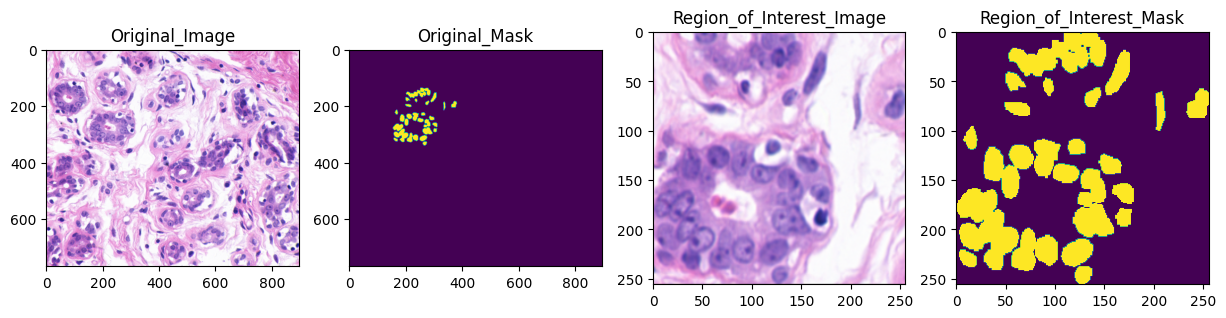

In [4]:
import matplotlib.pyplot as plt
rows = 1
columns = 4
Figure = plt.figure(figsize=(15,15))
Image_List = [Init_Image[0], Init_Mask[0], Train_X[0], Train_Y[0]]
p= ['Original_Image', 'Original_Mask', 'Region_of_Interest_Image', 'Region_of_Interest_Mask']
n=0
for i in range(1, rows*columns + 1):
    Image = Image_List[i-1]
    Sub_Plot_Image = Figure.add_subplot(rows, columns, i)
    Sub_Plot_Image.imshow(np.squeeze(Image))
    plt.title(p[n])
    n +=1
plt.show()

- Zero Padding
  - `Preserve Dimensions:` Zero padding retains the original dimensions of the input tensor during convolution, which is important for tasks like image segmentation.
  - `Control Output Size:` Zero padding ensures the output tensor size matches desired dimensions, especially in U-Net architectures where input and output sizes must align.
  - `Avoid Information Loss:` Pixels near the edges are involved in fewer convolutions than central pixels, leading to potential information loss. Padding ensures every pixel is treated equally.
  - `Better Performance:` By maintaining the spatial dimensions, zero padding helps the network extract features effectively, especially for deeper layers.
  - Types of Padding
    - `Valid Padding:` No padding is applied; the output size decreases.
    - `Same Padding:` Zero padding is applied to maintain the same dimensions between input and output.
- `Filter`: A filter (or kernel) is a small matrix that slides over input data to perform convolution, extracting features like edges, textures, and patterns (e.g., A 3x3 filter would have 9 weights).
- `Stride` is the step size by which the filter or kernel moves across the input during convolution or pooling operations.
  - *A stride of 1* moves the filter by one pixel at a time, resulting in a larger output.
  - *A stride of 2* skips every alternate pixel, reducing the output size.
  - $\text{Output Size} =  \large \frac{\text{Input Size} - \text{Filter Size} + 2 \times \text{Padding}}{\text{Stride}} + 1$
    - Input Size (L) = 32
    - Filter Size (K) = 3
    - Padding (P), (P=0,valid padding)
    - Stride (S) = 1
    - $\text{Output Size} = \frac{32 - 3 + 2 \times 1}{1} + 1 = \frac{30 + 2}{1} + 1 = 32$
- `Pooling` reduces the spatial dimensions of the feature map, lowering computational complexity and capturing dominant features.
   - Max Pooling: 2×2 window, [1, 3; 2, 4] → 4.
   - Average Pooling: 2×2 window, [1, 3; 2, 4] → 2.5.
- `Upsampling` increases feature map dimensions, used in image segmentation and super-resolution. Methods include Nearest Neighbor Upsampling, which fills new positions with the nearest pixel value, and Bilinear Interpolation, which uses weighted averages for smoother outputs.
- `Unpooling` Unpooling reverses pooling to restore feature map resolution, used in image reconstruction or segmentation. Max unpooling replaces max values from pooling in original positions, filling others with zeros.

In [ ]:
# 5. Implementation of U_NET Model for Semantic Segmentation

from tensorflow.keras import layers, models, callbacks


def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    
    
    inputs = layers.Input(input_size)
    n = layers.Lambda(lambda x:x/255)(inputs)
    
    c1 = layers.Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(n)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)


    c3 = layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)


    c4 = layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)


    c5 = layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c5)


    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c6)   

    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c7) 

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = layers.Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
    outputs = layers.Conv2D(1,(1,1), activation='sigmoid')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[Mean_IOU_Evaluator])
    # model.summary()
    return model

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# 6. Define U_NET Model Evaluator (Intersection Over Union _ IOU)
# def Mean_IOU_Evaluator(y_true, y_pred):
#     prec = []

#     # Loop over thresholds from 0.5 to 0.95 (step of 0.05)
#     for t in np.arange(0.5, 1, 0.05):
#         # Update deprecated functions
#         y_pred_ = tf.cast(y_pred > t, tf.int32)  # Replace tf.to_int32 with tf.cast
#         metric = tf.keras.metrics.MeanIoU(num_classes=2)  # Updated MeanIoU usage
#         metric.update_state(y_true, y_pred_)
#         prec.append(metric.result())  # Append IOU result for the threshold

#     # Return the mean IOU across all thresholds
#     return K.mean(K.stack(prec), axis=0)
model = U_Net_Segmentation()

def Mean_IOU_Evaluator(y_true, y_pred):
    prec = []
    metric = tf.keras.metrics.MeanIoU(num_classes=2)  # Create the metric instance outside the loop

    # Loop over thresholds from 0.5 to 0.95 (step of 0.05)
    for t in np.arange(0.5, 1, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)  # Apply threshold
        
        # Reset the internal variables of MeanIoU
        metric.update_state([], [])  # Workaround to clear previous state

        metric.update_state(y_true, y_pred_)
        prec.append(metric.result().numpy())  # Append IOU result for the threshold

    # Return the mean IOU across all thresholds
    return K.mean(K.stack(prec), axis=0)


In [ ]:
# # 6. Define U_NET Model Evaluator (Intersection Over Union _ IOU)
# from tensorflow.keras import backend as k
# def Mean_IOU_Evaluator(y_true, y_pred):
    
#     prec = []
    
#     for t in np.arange(0.5, 1, 0.05):
        
#         # y_pred_ = tf.to_int32(y_pred>t)
#         y_pred_ = tf.cast(y_pred > t, tf.int32)  # Replace tf.to_int32 with tf.cast
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         k.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return k.mean(k.stack(prec), axis = 0)

# model = U_Net_Segmentation()

In [10]:
imageset = 'BCC'
backbone = 'UNET'
version = 'v1.0'

# Correct file path to end with .keras
model_keras = 'model-{imageset}-{backbone}-{version}.keras'.format(
    imageset=imageset, backbone=backbone, version=version
)

# Callbacks
earlystopper = callbacks.EarlyStopping(patience=7, verbose=1)
checkpointer = callbacks.ModelCheckpoint(
    filepath=model_keras,  # Use the correct file path ending with .keras
    verbose=1,
    save_best_only=True
)

In [ ]:
# 7. Show The Results per Epoch

class loss_history(keras.callbacks.Callback):
    
    def __init__ (self, x=4):
        self.x = x
        
    def on_epoch_begin(self, epoch, logs={}):
        
        io.imshow(Train_X[self.x])
        plt.show()
        
        io.imshow(np.squeeze(Train_Y[self.x]))
        plt.show()
        
        preds_train = self.model.predict(np.expand_dims(Train_X[self.x], axis = 0))
        io.imshow(np.squeeze(preds_train[0]))
        plt.show()


In [17]:

history = model.fit(Train_X, Train_Y,
                    validation_split=0.1,
                    batch_size=2,
                    epochs=5)


Epoch 1/5


ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.

In [38]:
# 7. Show The Results per Epoch

class loss_history(callbacks.Callback):

    def __init__ (self, x=4):
        self.x = x
    
    def on_epoch_begin(self, epoch, logs=None):
        
        io.imshow(Train_X[self.x])
        plt.show()
        
        io.imshow(np.squeeze(Train_Y[self.x]))
        plt.show()
        
        preds_train = self.model.predict(np.expand_dims(Train_X[self.x], axis = 0))
        io.imshow(np.squeeze(preds_train[0]))
        plt.show()

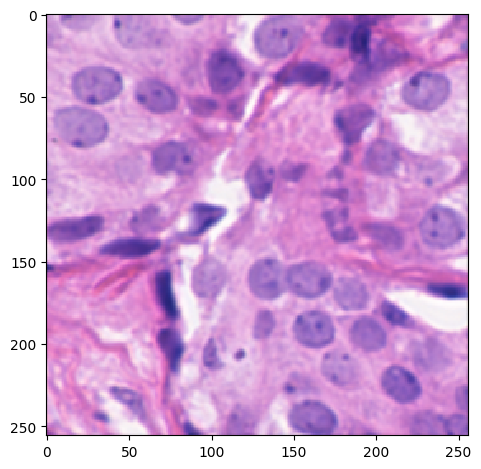

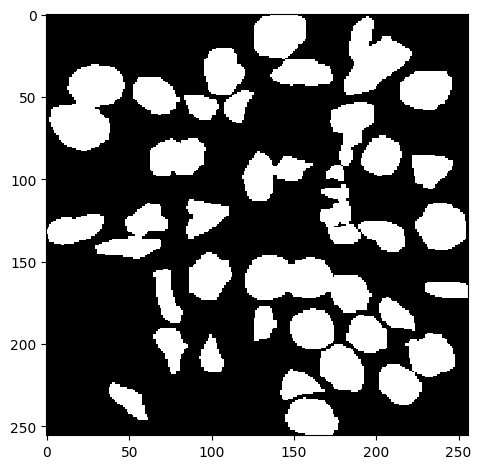

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


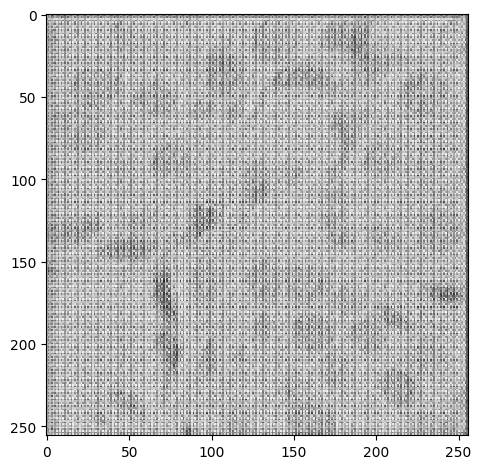

Epoch 1/20


AttributeError: 'NoneType' object has no attribute 'items'

In [21]:
# 8. Train U_NET Model using Training Samples

results = model.fit(Train_X, Train_Y, 
                    validation_split=0.1, 
                    batch_size=2,
                    epochs=20,
                    callbacks=[earlystopper, checkpointer, loss_history()]
                    )

In [ ]:
# def plot_img_original_augment(self, num_img: int) -> None:
        
#         _, axs = plt.subplots(nrows=2, ncols=num_img)
#          # Check if num_img is 1 (special case for 1 image)
#         if num_img == 1:
#             # Display images on the first row
#             # io.imread(files_inputs[0])[:, :, :3].shape
#             axs[0].imshow(io.imread(glob.glob(self.file_path + '/*')[0]), cmap='gray')
#             axs[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
#             [spine.set_visible(False) for spine in axs[0].spines.values()]  # Hide all spines
#             axs[0].set_ylabel("Original Images", fontsize=12, labelpad=10)  # Y-axis label for the first row
            
#             # Display images on the second row
#             axs[1].imshow(io.imread(glob.glob(self.ugmente_path + '/*')[0]), cmap='gray')
#             axs[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
#             [spine.set_visible(False) for spine in axs[1].spines.values()]  # Hide all spines
            # axs[1].set_ylabel("Augmented Images", fontsize=12, labelpad=10)  # Y-axis label for the second row

    #     else:
    #         for i in range(num_img):
    #             # Display images on the first row
    #             axs[0, i].imshow(io.imread(glob.glob(self.imag_files_path + '/*')[i]), cmap='gray')
    #             axs[0, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
    #             [spine.set_visible(False) for spine in axs[0, i].spines.values()]  # Hide all spines

    #             # Display images on the second row
    #             axs[1, i].imshow(io.imread(glob.glob(self.imag_augmented_path + '/*')[i]), cmap='gray')
    #             axs[1, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
    #             [spine.set_visible(False) for spine in axs[1, i].spines.values()]  # Hide all spines

    #         # Add ylabel for each row (only set ylabel for the first column of each row)
    #         axs[0, 0].set_ylabel("Original Images", fontsize=12, labelpad=10)  # Y-axis label for the first row
    #         axs[1, 0].set_ylabel("Augmented Images", fontsize=12, labelpad=10)  # Y-axis label for the second row

    #     # Adjust layout to make sure images and titles don't overlap
    #     plt.tight_layout()

    #     # Auto-scale to fit the images in the figure area
    #     plt.autoscale(enable=True, axis='both', tight=True)
    #     plt.show()
        
# from skimage import transform, color  
